In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### BÀI TẬP 2.2.3: SUPPORT VECTOR MACHINE - BỆNH TIỂU ĐƯỜNG

#### PHẦN 1: NẠP VÀ KHÁM PHÁ DỮ LIỆU

In [7]:
print("\n[1] NẠP VÀ KHÁM PHÁ DỮ LIỆU")
print("-" * 70)

try:
    df = pd.read_csv('diabetes_prediction_dataset.csv')
    print(" Đã nạp dữ liệu thành công!")
except FileNotFoundError:
    print(" Không tìm thấy file 'diabetes_prediction_dataset.csv'")
    print("Vui lòng tải dataset từ:")
    print("https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database")
    exit()

print(f"\nKích thước: {df.shape}")
print(f"Các cột: {df.columns.tolist()}")
print(f"\n5 dòng đầu:")
print(df.head())

print(f"\nPhân bố nhãn:")
print(df['diabetes'].value_counts())
print(f"\nTỷ lệ:")
print(df['diabetes'].value_counts(normalize=True))


[1] NẠP VÀ KHÁM PHÁ DỮ LIỆU
----------------------------------------------------------------------
 Đã nạp dữ liệu thành công!

Kích thước: (100000, 9)
Các cột: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

5 dòng đầu:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                 

#### PHẦN 2: TIỀN XỬ LÝ DỮ LIỆU

In [8]:
print("\n[2] TIỀN XỬ LÝ DỮ LIỆU")
print("-" * 70)

data = df.copy()

# Thay thế giá trị 0 bằng median
print("\nThay thế giá trị 0 bằng median...")
cols_to_replace = ['blood_glucose_level', 'hypertension', 'heart_disease', 'HbA1c_level', 'bmi']

for col in cols_to_replace:
    median_val = data[data[col] != 0][col].median()
    data[col] = data[col].replace(0, median_val)
    print(f"  {col}: thay {(df[col] == 0).sum()} giá trị 0 bằng {median_val:.2f}")

# Tạo features mới
print("\nTạo features mới...")
data['BMI_Category'] = pd.cut(data['bmi'], 
                               bins=[0, 18.5, 25, 30, 100],
                               labels=[0, 1, 2, 3])
data['Age_Group'] = pd.cut(data['age'],
                            bins=[0, 30, 40, 50, 100],
                            labels=[0, 1, 2, 3])
data['Glucose_Level'] = pd.cut(data['blood_glucose_level'],
                                bins=[0, 100, 125, 200],
                                labels=[0, 1, 2])
data['Glucose_Level'].fillna(0, inplace=True) 
data['BMI_Category'].fillna(0, inplace=True)
data['Age_Group'].fillna(0, inplace=True)
# Chuyển sang numeric
data['BMI_Category'] = data['BMI_Category'].astype(int)
data['Age_Group'] = data['Age_Group'].astype(int)
data['Glucose_Level'] = data['Glucose_Level'].astype(int)

# Chuẩn bị features và target
feature_cols = df.columns[:-1].tolist() + ['BMI_Category', 'Age_Group', 'Glucose_Level']
X = data[feature_cols]
y = data['diabetes']

print(f"\nSố lượng features: {len(feature_cols)}")
print(f"Features: {feature_cols}")
print(f"Kích thước X: {X.shape}, y: {y.shape}")

categorical_cols = ['gender', 'smoking_history']

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True) 
data.fillna(0, inplace=True) 

feature_cols = data.columns.drop('diabetes').tolist()

X = data[feature_cols]
y = data['diabetes']




[2] TIỀN XỬ LÝ DỮ LIỆU
----------------------------------------------------------------------

Thay thế giá trị 0 bằng median...
  blood_glucose_level: thay 0 giá trị 0 bằng 140.00
  hypertension: thay 92515 giá trị 0 bằng 1.00
  heart_disease: thay 96058 giá trị 0 bằng 1.00
  HbA1c_level: thay 0 giá trị 0 bằng 5.80
  bmi: thay 0 giá trị 0 bằng 27.32

Tạo features mới...

Số lượng features: 11
Features: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'BMI_Category', 'Age_Group', 'Glucose_Level']
Kích thước X: (100000, 11), y: (100000,)


#### PHẦN 3: CHIA DỮ LIỆU VÀ CHUẨN HÓA


In [9]:
print("\n[3] CHIA DỮ LIỆU VÀ CHUẨN HÓA")
print("-" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Chuẩn hóa dữ liệu (QUAN TRỌNG cho SVM!)
print("\nChuẩn hóa dữ liệu với StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Đã chuẩn hóa dữ liệu!")
print(f"Mean trước chuẩn hóa: {X_train.mean().mean():.2f}")
print(f"Mean sau chuẩn hóa: {X_train_scaled.mean():.2f}")
print(f"Std sau chuẩn hóa: {X_train_scaled.std():.2f}")



[3] CHIA DỮ LIỆU VÀ CHUẨN HÓA
----------------------------------------------------------------------
Train set: (80000, 16)
Test set: (20000, 16)

Chuẩn hóa dữ liệu với StandardScaler...
 Đã chuẩn hóa dữ liệu!
Mean trước chuẩn hóa: 13.79
Mean sau chuẩn hóa: 0.00
Std sau chuẩn hóa: 0.94


#### PHẦN 4: XÂY DỰNG SVM CƠ BẢN

In [10]:
print("\n[4] XÂY DỰNG SVM CƠ BẢN")
print("-" * 70)

# 4.1. SVM với kernel RBF (mặc định)
print("\n4.1. SVM với kernel RBF (default)")
svm_basic = SVC(kernel='rbf', random_state=42)
svm_basic.fit(X_train_scaled, y_train)

train_acc_basic = svm_basic.score(X_train_scaled, y_train)
test_acc_basic = svm_basic.score(X_test_scaled, y_test)

print(f"Accuracy trên train: {train_acc_basic:.4f}")
print(f"Accuracy trên test: {test_acc_basic:.4f}")



[4] XÂY DỰNG SVM CƠ BẢN
----------------------------------------------------------------------

4.1. SVM với kernel RBF (default)
Accuracy trên train: 0.9647
Accuracy trên test: 0.9645


#### PHẦN 5: SO SÁNH CÁC KERNEL


[5] SO SÁNH CÁC KERNEL
----------------------------------------------------------------------

Đang huấn luyện với các kernel khác nhau...

  Kernel: linear
    Train: 0.9630, Test: 0.9627, CV: 0.9630 ± 0.0012

  Kernel: poly
    Train: 0.9653, Test: 0.9650, CV: 0.9653 ± 0.0011

  Kernel: rbf
    Train: 0.9647, Test: 0.9645, CV: 0.9642 ± 0.0010

  Kernel: sigmoid
    Train: 0.9185, Test: 0.9213, CV: 0.9195 ± 0.0014

--- Bảng so sánh các Kernel ---
 Kernel  Train Acc  Test Acc  CV Mean   CV Std
 linear   0.963000   0.96265 0.963025 0.001220
   poly   0.965287   0.96500 0.965275 0.001143
    rbf   0.964712   0.96445 0.964238 0.001045
sigmoid   0.918488   0.92130 0.919538 0.001381


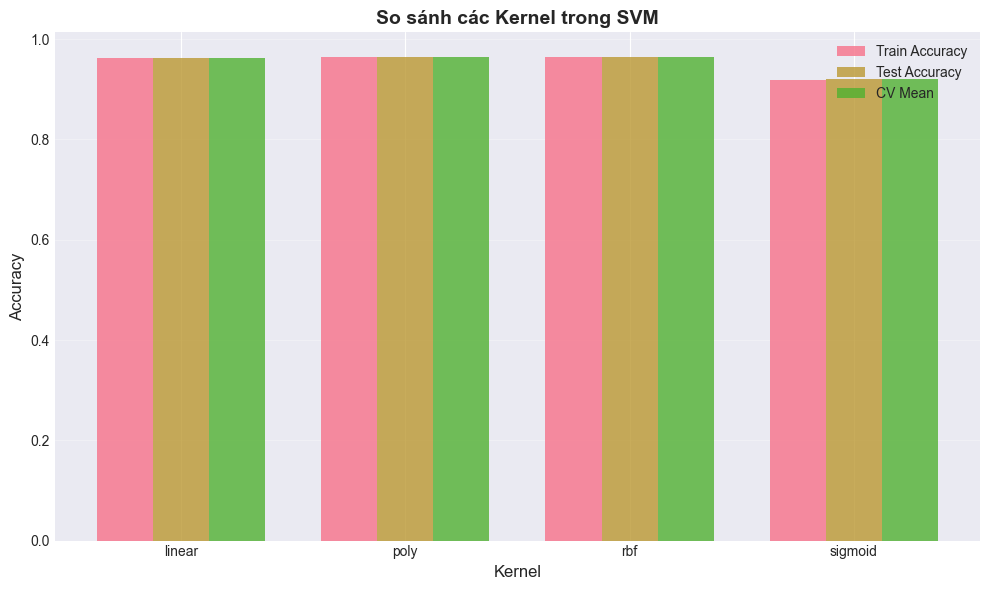

In [11]:
print("\n[5] SO SÁNH CÁC KERNEL")
print("-" * 70)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_results = []

print("\nĐang huấn luyện với các kernel khác nhau...")
for kernel in kernels:
    print(f"\n  Kernel: {kernel}")
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    train_acc = svm.score(X_train_scaled, y_train)
    test_acc = svm.score(X_test_scaled, y_test)
    
    # Cross-validation
    cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    kernel_results.append({
        'Kernel': kernel,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"    Train: {train_acc:.4f}, Test: {test_acc:.4f}, CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Hiển thị bảng so sánh
kernel_df = pd.DataFrame(kernel_results)
print("\n--- Bảng so sánh các Kernel ---")
print(kernel_df.to_string(index=False))

# Vẽ biểu đồ so sánh
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(kernels))
width = 0.25

ax.bar(x_pos - width, kernel_df['Train Acc'], width, label='Train Accuracy', alpha=0.8)
ax.bar(x_pos, kernel_df['Test Acc'], width, label='Test Accuracy', alpha=0.8)
ax.bar(x_pos + width, kernel_df['CV Mean'], width, label='CV Mean', alpha=0.8)

ax.set_xlabel('Kernel', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('So sánh các Kernel trong SVM', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(kernels)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


#### PHẦN 6: TỐI ƯU HÓA THAM SỐ

In [12]:
print("\n[6] TỐI ƯU HÓA THAM SỐ VỚI GRIDSEARCHCV")
print("-" * 70)

# Tìm kernel tốt nhất
best_kernel = kernel_df.loc[kernel_df['Test Acc'].idxmax(), 'Kernel']
print(f"\nKernel tốt nhất: {best_kernel}")

# GridSearchCV với kernel tốt nhất
print(f"\nĐang tối ưu hóa tham số cho kernel '{best_kernel}'...")

if best_kernel == 'linear':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear']
    }
elif best_kernel == 'poly':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
else:  # rbf or sigmoid
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': [best_kernel],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }

svm = SVC(random_state=42)
grid_search = GridSearchCV(
    svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n Tham số tốt nhất: {grid_search.best_params_}")
print(f" Accuracy tốt nhất (CV): {grid_search.best_score_:.4f}")

# Đánh giá mô hình tốt nhất
best_svm = grid_search.best_estimator_
train_acc_best = best_svm.score(X_train_scaled, y_train)
test_acc_best = best_svm.score(X_test_scaled, y_test)

print(f"\nAccuracy trên train: {train_acc_best:.4f}")
print(f"Accuracy trên test: {test_acc_best:.4f}")


[6] TỐI ƯU HÓA THAM SỐ VỚI GRIDSEARCHCV
----------------------------------------------------------------------

Kernel tốt nhất: poly

Đang tối ưu hóa tham số cho kernel 'poly'...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Tham số tốt nhất: {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
 Accuracy tốt nhất (CV): 0.9687

Accuracy trên train: 0.9688
Accuracy trên test: 0.9689


#### PHẦN 7: PHÂN TÍCH ẢNH HƯỞNG CỦA THAM SỐ C


[7] PHÂN TÍCH ẢNH HƯỞNG CỦA THAM SỐ C
----------------------------------------------------------------------

Đánh giá với các giá trị C khác nhau...
  C=  0.001: Train=0.9437, Test=0.9452
  C=  0.010: Train=0.9592, Test=0.9593
  C=  0.100: Train=0.9624, Test=0.9627
  C=  1.000: Train=0.9653, Test=0.9650
  C= 10.000: Train=0.9653, Test=0.9649
  C=100.000: Train=0.9688, Test=0.9689
  C=1000.000: Train=0.9685, Test=0.9685


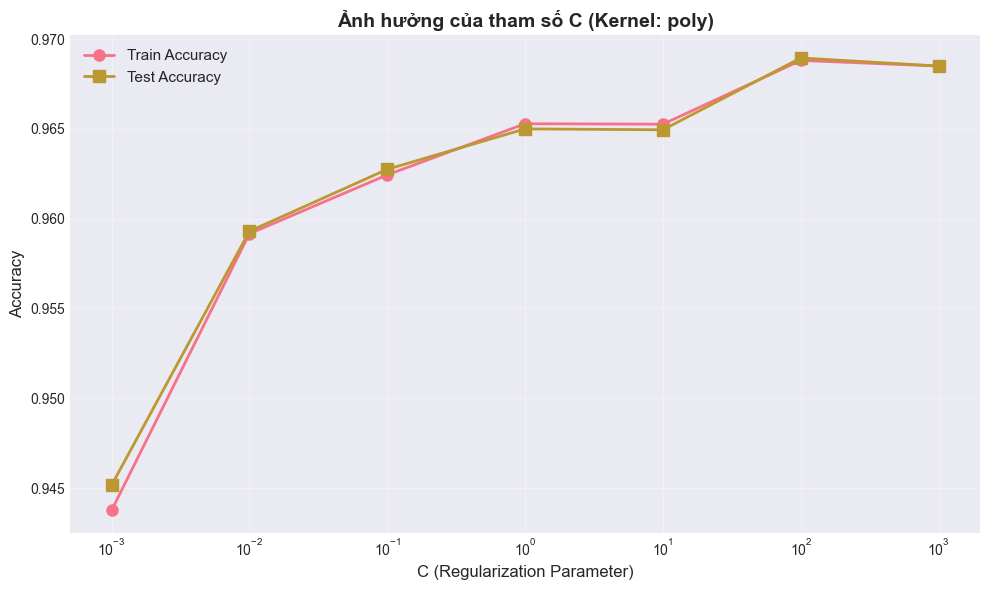

In [13]:
print("\n[7] PHÂN TÍCH ẢNH HƯỞNG CỦA THAM SỐ C")
print("-" * 70)

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []

print("\nĐánh giá với các giá trị C khác nhau...")
for C in C_values:
    svm = SVC(kernel=best_kernel, C=C, gamma='scale', random_state=42)
    svm.fit(X_train_scaled, y_train)
    train_scores.append(svm.score(X_train_scaled, y_train))
    test_scores.append(svm.score(X_test_scaled, y_test))
    print(f"  C={C:7.3f}: Train={train_scores[-1]:.4f}, Test={test_scores[-1]:.4f}")

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_scores, 'o-', label='Train Accuracy', linewidth=2, markersize=8)
plt.semilogx(C_values, test_scores, 's-', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f'Ảnh hưởng của tham số C (Kernel: {best_kernel})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### PHẦN 8: ĐÁNH GIÁ CHI TIẾT


[8] ĐÁNH GIÁ CHI TIẾT MÔ HÌNH TỐT NHẤT
----------------------------------------------------------------------


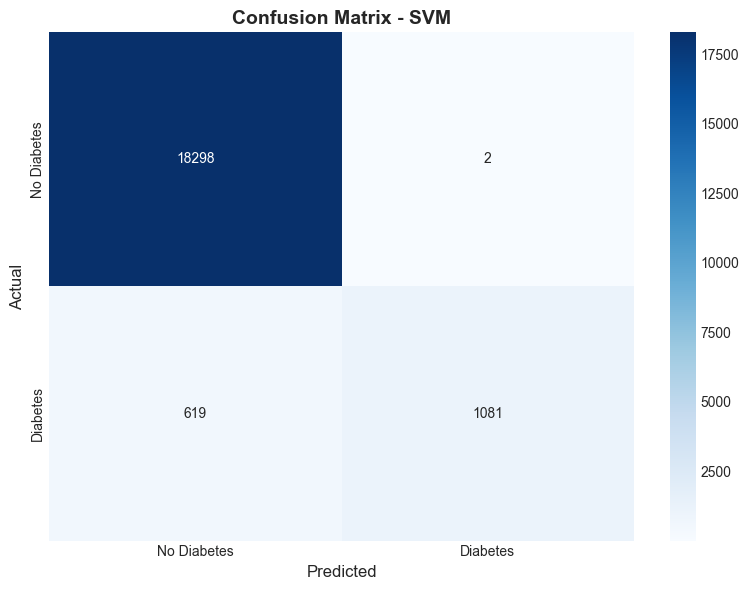


--- Classification Report ---
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.98     18300
    Diabetes       1.00      0.64      0.78      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.82      0.88     20000
weighted avg       0.97      0.97      0.97     20000



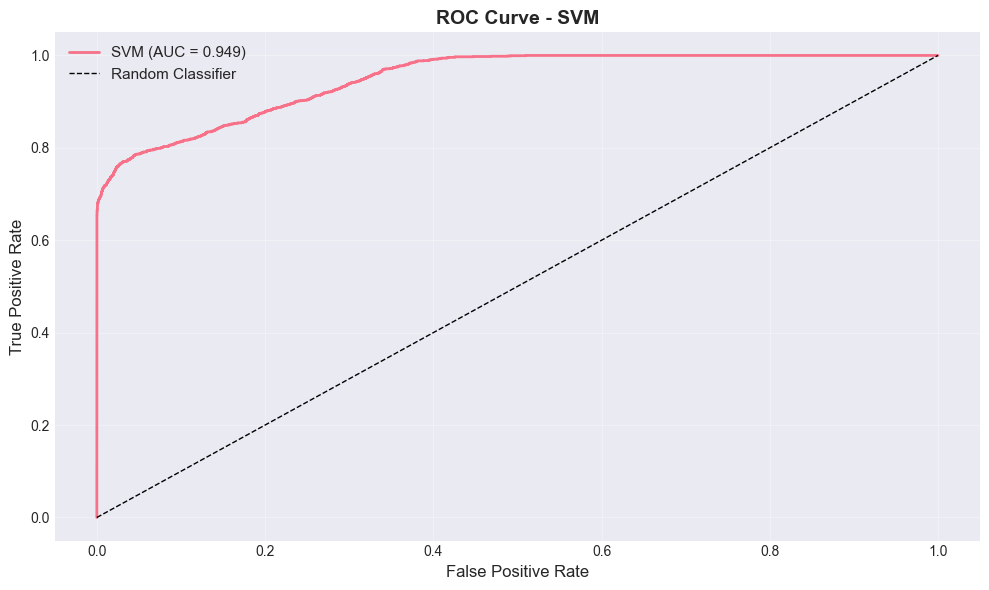

In [14]:
print("\n[8] ĐÁNH GIÁ CHI TIẾT MÔ HÌNH TỐT NHẤT")
print("-" * 70)

# Dự đoán
y_pred = best_svm.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - SVM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

# ROC Curve
if hasattr(best_svm, 'predict_proba'):
    y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
else:
    # Sử dụng decision_function nếu không có predict_proba
    best_svm_prob = SVC(kernel=best_kernel, C=grid_search.best_params_['C'], 
                        gamma=grid_search.best_params_.get('gamma', 'scale'),
                        probability=True, random_state=42)
    best_svm_prob.fit(X_train_scaled, y_train)
    y_pred_proba = best_svm_prob.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'SVM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SVM', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### PHẦN 9: SO SÁNH TẤT CẢ MÔ HÌNH

In [15]:
print("\n[9] SO SÁNH TẤT CẢ MÔ HÌNH SVM")
print("=" * 70)

# Thêm kết quả mô hình tốt nhất
kernel_results.append({
    'Kernel': f'{best_kernel} (Tuned)',
    'Train Acc': train_acc_best,
    'Test Acc': test_acc_best,
    'CV Mean': grid_search.best_score_,
    'CV Std': 0
})

comparison_df = pd.DataFrame(kernel_results)
print(comparison_df.to_string(index=False))


[9] SO SÁNH TẤT CẢ MÔ HÌNH SVM
      Kernel  Train Acc  Test Acc  CV Mean   CV Std
      linear   0.963000   0.96265 0.963025 0.001220
        poly   0.965287   0.96500 0.965275 0.001143
         rbf   0.964712   0.96445 0.964238 0.001045
     sigmoid   0.918488   0.92130 0.919538 0.001381
poly (Tuned)   0.968812   0.96895 0.968712 0.000000
